### Abstract

This notebook is intended to showcase how to use the MNL (Multinomial Logistic Regression) model to predict the booking probability for each option within a session.

One can find the sample training and testing data under the `data` folder.

In [2]:
# import the model and all the auxiliary functions
from MNL import *
from MNL_plus import *
from Mint import *

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np

import pprint 
pp = pprint.PrettyPrinter(indent=4)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6
rcParams['figure.dpi'] = 100
rcParams['savefig.dpi'] = 100

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-y4pkclcl because the default path (/home/jovyan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
# To save output into txt file
from contextlib import redirect_stdout

In [ ]:
TRAIN_CONFIG = {
    #'MNL_features': MNL_features,
    
    # when absent, by default, use all the features within the training data
    #'alter_features': MNL_features,
    #'session_features'
    
    # options: BinaryCrossEntropy, MaxLogLikelihood
    #'loss':  'MaxLogLikelihood',
    'loss':  'MaxLogLikelihood',
    
    'expand': False,
    
    'optimizer': 'Adam',  # options:  Adam, RMSprop, SGD, LBFGS.
    # Adam would converge much faster
    # LBFGS is a very memory intensive optimizer (it requires additional param_bytes * (history_size + 1) bytes).
    # If it doesn’t fit in memory try reducing the history size, or use a different algorithm.
    # By default, history_size == 100
    'learning_rate': 0.1, # Applicable to Adam, SGD, and LBFGS
    # The learning_rate parameter seems essential to LBFGS, which converges in two epochs.
    #  So far, learning_rate == 0.1 seems to be ok for LBFGS
    
    #'momentum': 0.9,  # applicable to SGD, RMSprop
    'momentum': 0.01,  # applicable to SGD, RMSprop
    
    # The resulting model seems to be more balanced, i.e. no extreme large/small weights,
    #  although one might not have the most ideal performance, i.e. high top_5_rank etc.
    'weight_decay': 0, # Applicable to Adam, RMSprop and SGD
    

    # indicates the number of sessions included in each batch
    'batch_size': 1
    
    #maximum number of epochs
    'epochs': 20,
    
    #tolerance for early stopping
    'early_stop_min_delta': 1e-4,
    'patience': 5,
    
    #if able to use GPU (unfortunately I am not able to do this)
    'gpu': False,  # luckily, running on GPU is faster than CPU in this case.
    
    # level of logging, 0: no log,  1: print epoch related logs;  2: print session related logs
    'verbose': 1,
    
    # Adding the regularization degredates the performance of model
    #   which might suggests that the model is still underfitting, not overfitting.
    'l1_loss_weight': 0,  # e.g. 0.001 the regularization that would marginalize the weights
    'l2_loss_weight': 0,
    
    # flag indicates whether to save gradients during the training
    'save_gradients': False

}


In [ ]:
# set random seed for reproduceability
np.random.seed(17)
torch.manual_seed(17)

df_train = pd.read_csv('data/train_SINBKK_RT_B.csv')

# Create a brand-new model
from contextlib import redirect_stdout

with open('out.txt', 'w') as f:
    with redirect_stdout(f):
        model_tuple, loss_list = run_training(df_training=df_train, train_config=TRAIN_CONFIG)

# Continue training on the existing model
model_tuple, loss_list = run_training(df_training=df_train, train_config=TRAIN_CONFIG, model_tuple=model_tuple)


# unzip the tuple
(model, loss, optimizer) = model_tuple


# plot the evolution of loss
plot_loss(loss_list)

### Model Stats

In this section, we calculate some statistics in the train data

In [ ]:
# Test the model with the testing data
# Calculate the probability and the trank of the chosen alternative
train_stats = validate(model, df_train, TRAIN_CONFIG)
train_stats.head()

Summarize the testing results into a list of KPIs, such as:

- *mean_probability*: the average probability of the predicted alternative among all sessions


- *top_5_rank_quantile*: the percentile of sessions where the probability of the predicted alternative is among the top 5.


- *AIC*: Akaike Information Criterion, which offers an estimate of the relative information lost when a given model is used to represent the process that generated the data.

In [ ]:
summarize_KPIs(train_stats, len(TRAIN_CONFIG['MNL_features']))

In [ ]:
model.get_feature_weights()

## Implementation with expand option 

In this section, I show how to use the expand option. You will see that there are three datasets this time (take a look at the dummy do file in the data folder to see how they are constructed)

In [11]:
session_id=['session_id']
alter_id=['alter_id']
alter_features=['reco_contains_mh', 'reco_contains_tg', 'reco_contains_pg', 'reco_contains_sq', 'reco_contains_vn', 'reco_contains_cx', 'reco_contains_od']
session_features=['deptime_outbound_sin2p', 'deptime_outbound_sin4p', 'deptime_outbound_cos2p', 'deptime_outbound_cos4p', 'deptime_inbound_sin2p', 'deptime_inbound_sin4p', 'deptime_inbound_cos2p', 'deptime_inbound_cos4p']
choice_groups=['group','group2']
session_alter_features=['session_alter_feature']

In [12]:
#define choice-alternative function
def session_alter(data):
    return data['reco_contains_mh']*data['deptime_outbound_sin4p']+data['deptime_outbound_cos4p']

In [13]:
TRAIN_CONFIG = {
    #'MNL_features': MNL_features,
    
    # when absent, by default, use all the features within the training data
    #'alter_features': MNL_features,
    #'session_features'
    'alter_features':alter_features,
    'session_features':session_features,
    'choice_groups':choice_groups,
    'session_alter_features':session_alter_features,
    
    # options: BinaryCrossEntropy, MaxLogLikelihood
    #'loss':  'MaxLogLikelihood',
    'loss':  'MaxLogLikelihood',
    
    'expand': True,
    
   'optimizer': 'Adam',  # options:  Adam, RMSprop, SGD, LBFGS.
    # Adam would converge much faster
    # LBFGS is a very memory intensive optimizer (it requires additional param_bytes * (history_size + 1) bytes).
    # If it doesn’t fit in memory try reducing the history size, or use a different algorithm.
    # By default, history_size == 100
    'learning_rate': 0.1, # Applicable to Adam, SGD, and LBFGS
    # The learning_rate parameter seems essential to LBFGS, which converges in two epochs.
    #  So far, learning_rate == 0.1 seems to be ok for LBFGS
    
    #'momentum': 0.9,  # applicable to SGD, RMSprop
    'momentum': 0.01,  # applicable to SGD, RMSprop
    
    # The resulting model seems to be more balanced, i.e. no extreme large/small weights,
    #  although one might not have the most ideal performance, i.e. high top_5_rank etc.
    'weight_decay': 0, # Applicable to Adam, RMSprop and SGD
    

    # indicates the number of sessions included in each batch
    'batch_size': 500,
    
    #maximum number of epochs
    'epochs': 20,
    
    #tolerance for early stopping
    'early_stop_min_delta': 1e-4,
    'patience': 5,
    
    #if able to use GPU (unfortunately I am not able to do this)
    'gpu': False,  # luckily, running on GPU is faster than CPU in this case.
    
    # level of logging, 0: no log,  1: print epoch related logs;  2: print session related logs
    'verbose': 1,
    
    # Adding the regularization degredates the performance of model
    #   which might suggests that the model is still underfitting, not overfitting.
    'l1_loss_weight': 0,  # e.g. 0.001 the regularization that would marginalize the weights
    'l2_loss_weight': 0,
    
    # flag indicates whether to save gradients during the training
    'save_gradients': True, 
    
    #choice alternative function name
    'session_alter_fn': session_alter
}


In [14]:
alter_data = pd.read_csv('data/train_SINBKK_RT_B_alter_id.csv')
session_data = pd.read_csv('data/train_SINBKK_RT_B_session_id.csv')
choices = pd.read_csv('data/train_SINBKK_RT_B_choices.csv')[['session_id','alter_id','choice','group','group2']]

In [16]:
TRAIN_CONFIG['batch_size']=500
model_tuple, loss_list = run_training(df_training=choices, train_config=TRAIN_CONFIG, alter_data=alter_data, session_data=session_data)
(model, loss, optimizer) = model_tuple
model.get_feature_weights()

Num features: 16
Alternative Features: ['reco_contains_mh', 'reco_contains_tg', 'reco_contains_pg', 'reco_contains_sq', 'reco_contains_vn', 'reco_contains_cx', 'reco_contains_od']
Session Features: ['deptime_outbound_sin2p', 'deptime_outbound_sin4p', 'deptime_outbound_cos2p', 'deptime_outbound_cos4p', 'deptime_inbound_sin2p', 'deptime_inbound_sin4p', 'deptime_inbound_cos2p', 'deptime_inbound_cos4p']
Group IDs: ['group', 'group2']
epoch: 0  loss: -6.778224781409323e-05 best_loss: 1000000000000000.0
epoch: 1  loss: -7.081620213265937e-05 best_loss: -6.778224781409323e-05
epoch: 2  loss: -7.222315081206426e-05 best_loss: -6.778224781409323e-05
epoch: 3  loss: -7.282930273613484e-05 best_loss: -6.778224781409323e-05
epoch: 4  loss: -7.334253830364483e-05 best_loss: -6.778224781409323e-05
epoch: 5  loss: -7.382423750832852e-05 best_loss: -6.778224781409323e-05
Early stopping!  epoch: 5 min_delta: 0.0001  patience: 5
Final epoch: 5  loss: -7.382423750832852e-05


{'reco_contains_mh': 0.24011158052452442,
 'reco_contains_tg': 2.3378173159111793,
 'reco_contains_pg': 0.07111990597607173,
 'reco_contains_sq': -2.0270991147630215,
 'reco_contains_vn': 0.18002406037989124,
 'reco_contains_cx': -1.2470184863469815,
 'reco_contains_od': 0.21191237672922855,
 'deptime_outbound_sin2p': -1.2256680970931693,
 'deptime_outbound_sin4p': 1.568020205603402,
 'deptime_outbound_cos2p': 0.6413090730277459,
 'deptime_outbound_cos4p': -0.8042177464401635,
 'deptime_inbound_sin2p': -0.7288084614409374,
 'deptime_inbound_sin4p': 1.2421833672585016,
 'deptime_inbound_cos2p': -1.835644034473684,
 'deptime_inbound_cos4p': -0.8876417098383934,
 'session_alter_feature': -0.7748999493498718}

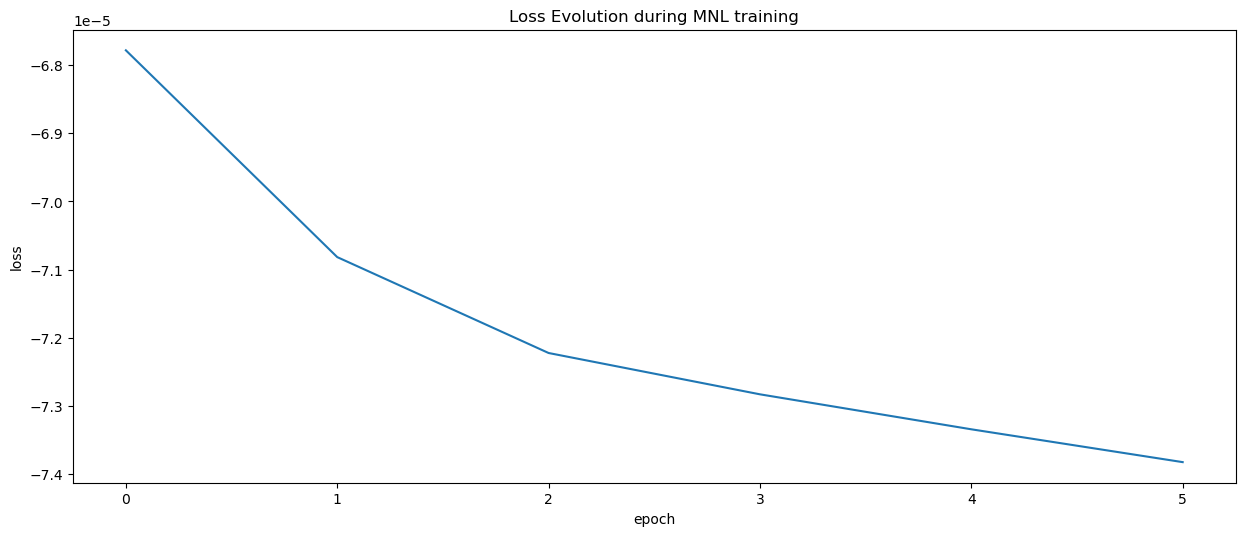

In [18]:
plot_loss(loss_list)

In [ ]:
TRAIN_CONFIG['batch_size']=1
model_tuple, loss_list = run_training(df_training=choices, train_config=TRAIN_CONFIG, alter_data=alter_data, session_data=session_data)
(model, loss, optimizer) = model_tuple
model.get_feature_weights()

Num features: 16
Alternative Features: ['reco_contains_mh', 'reco_contains_tg', 'reco_contains_pg', 'reco_contains_sq', 'reco_contains_vn', 'reco_contains_cx', 'reco_contains_od']
Session Features: ['deptime_outbound_sin2p', 'deptime_outbound_sin4p', 'deptime_outbound_cos2p', 'deptime_outbound_cos4p', 'deptime_inbound_sin2p', 'deptime_inbound_sin4p', 'deptime_inbound_cos2p', 'deptime_inbound_cos4p']
Group IDs: ['group', 'group2']
epoch: 0  loss: -19.67872139186661 best_loss: 1000000000000000.0


In [ ]:
plot(loss_list)

Get statistics

In [ ]:
choices = pd.read_csv('data/train_SINBKK_RT_B_choices.csv')[['session_id','alter_id','choice']+
                                                            alter_features + session_features + choice_groups + session_alter_features]
test_results = test_model(model, choices, TRAIN_CONFIG)
test_results.head()

In [ ]:
#Standard errors


In [ ]:
TRAIN_CONFIG['gradients'][-1]